<a href="https://colab.research.google.com/github/nahyeon-an/python/blob/main/ML/time-series/Trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


### Trend  
persistent, long-term change 를 나타내는 요소  
중요성의 가장 큰 시간 규모를 나타내는 slowest-moving part  

### Moving Average Plot  
트렌드를 보기위한 방법 중 하나  
슬라이딩 윈도를 이용해 값들의 평균을 구함  
단기적인 변동을 smooth -> 장기적인 변화만 남게  
(단기적인 변동 -> seasonal change)  

trend 모델링  
- time-step 피처를 이용하여 가능  
- linear trend model : target = a \* time + b  
- time dummy 에 여러 변형을 통해 다양한 트렌드 모델링 가능  
- ex) target = a \* time \*\* 2 + b \* time + c  
- Linear regression 은 a, b, c 를 학습  

In [1]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
simplefilter("ignore")

In [3]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [4]:
tunnel = pd.read_csv('tunnel.csv', parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period()
tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


In [5]:
# 1. rolling : window computation (compute average)
moving_average = tunnel.rolling(
    window=365,  # window size
    center=True,  # average center
    min_periods=183,  # half of window size
).mean()  # mean, median, std, min, max, ...

moving_average

,NumVehicles
Day,
2003-11-01,99127.426230
2003-11-02,99094.489130
2003-11-03,99112.481081
2003-11-04,99146.639785
2003-11-05,99196.122995
...,...
2005-11-12,112995.689840
2005-11-13,113058.763441
2005-11-14,113195.718919


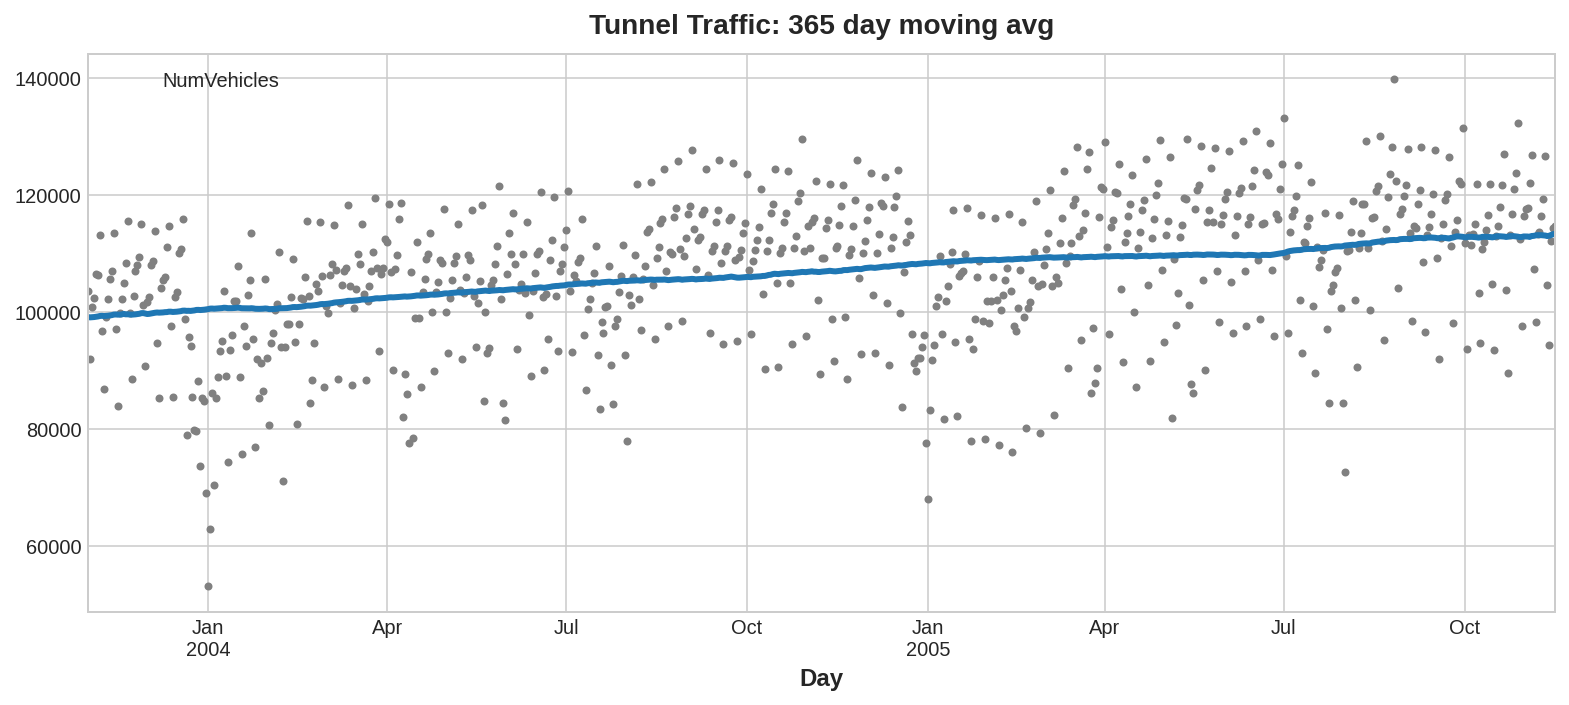

In [6]:
ax = tunnel.plot(style='.', color='0.5')
moving_average.plot(
    ax=ax, linewidth=3, title='Tunnel Traffic: 365 day moving avg', legend=False
)

statsmodels 의 DeterministicProcess 를 사용해보자  
- 시계열과 linear regression 을 이용할 때 발생가능한 tricky fail 을 피하기 위한 방법  
- order = polynomial order (1: linear, 2: quadratic, 3: cubic, ...)  

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess

In [8]:
dp = DeterministicProcess(
    index=tunnel.index,  # 학습셋에서 dates
    constant=True,  # dummy feature for bias (y절편)
    order=1,  # time dummy
    drop=True,  # collinearity 를 피해야할 때 true
)
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


deterministic process  
- 시계열이 non-random 이거나 constant, trend 가 완전히 결정되었을 때를 위한 방법  
- time index 에서 만들어진 피처도 deterministic  

In [9]:
from sklearn.linear_model import LinearRegression

y = tunnel['NumVehicles']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

In [10]:
y_pred.head()

Day
2003-11-01    98176.206344
2003-11-02    98198.703794
2003-11-03    98221.201243
2003-11-04    98243.698693
2003-11-05    98266.196142
Freq: D, dtype: float64

moving average 플롯과 동일한 결과를 볼 수 있음  
- linear trend 가 좋은 결정이었음을 보여줌  

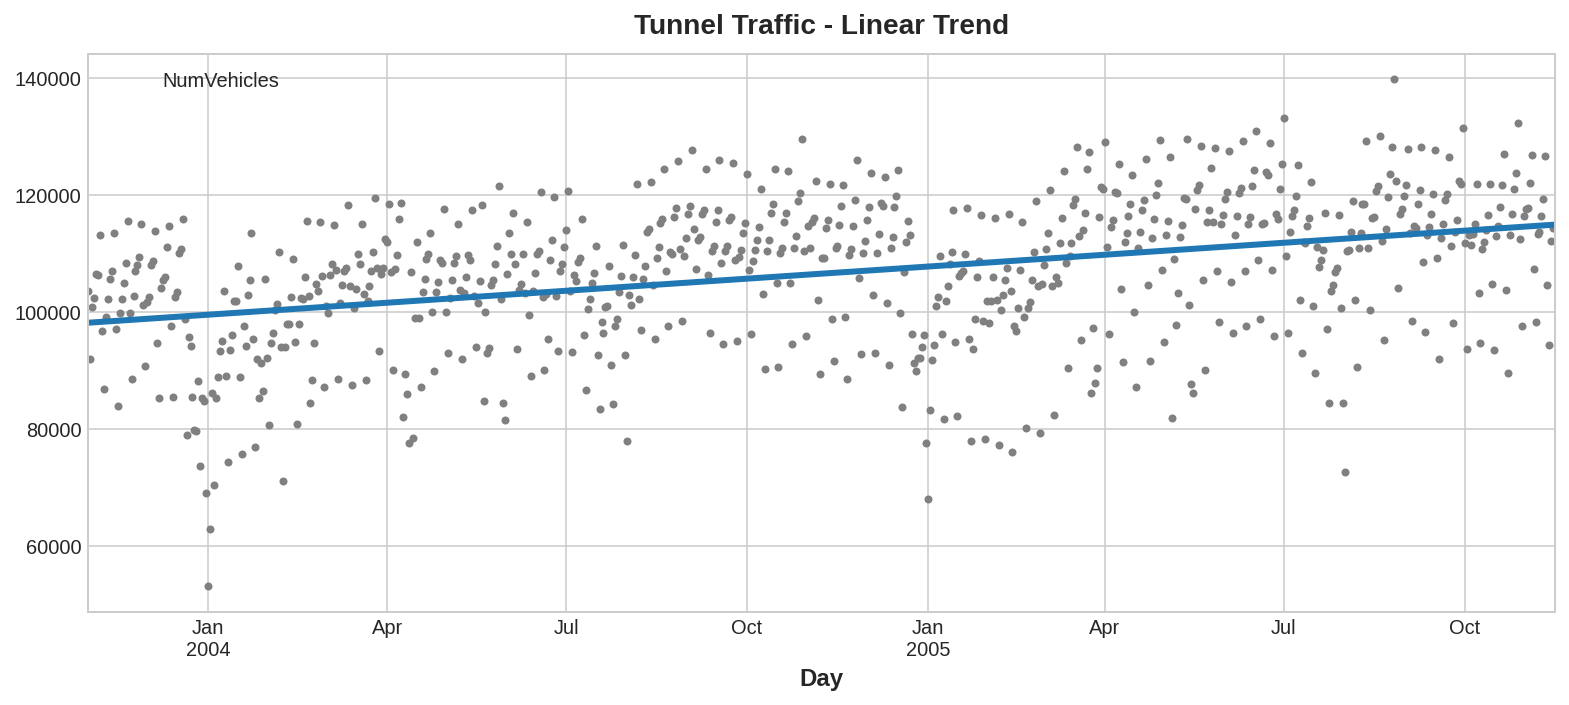

In [11]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

예측을 위해 "out of sample" 피처를 모델에 적용  
out of sample : 훈련셋의 관측 기간을 벗어나는 시간  

In [12]:
X = dp.out_of_sample(steps=30)
y_forecast = pd.Series(model.predict(X), index=X.index)

y_forecast.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

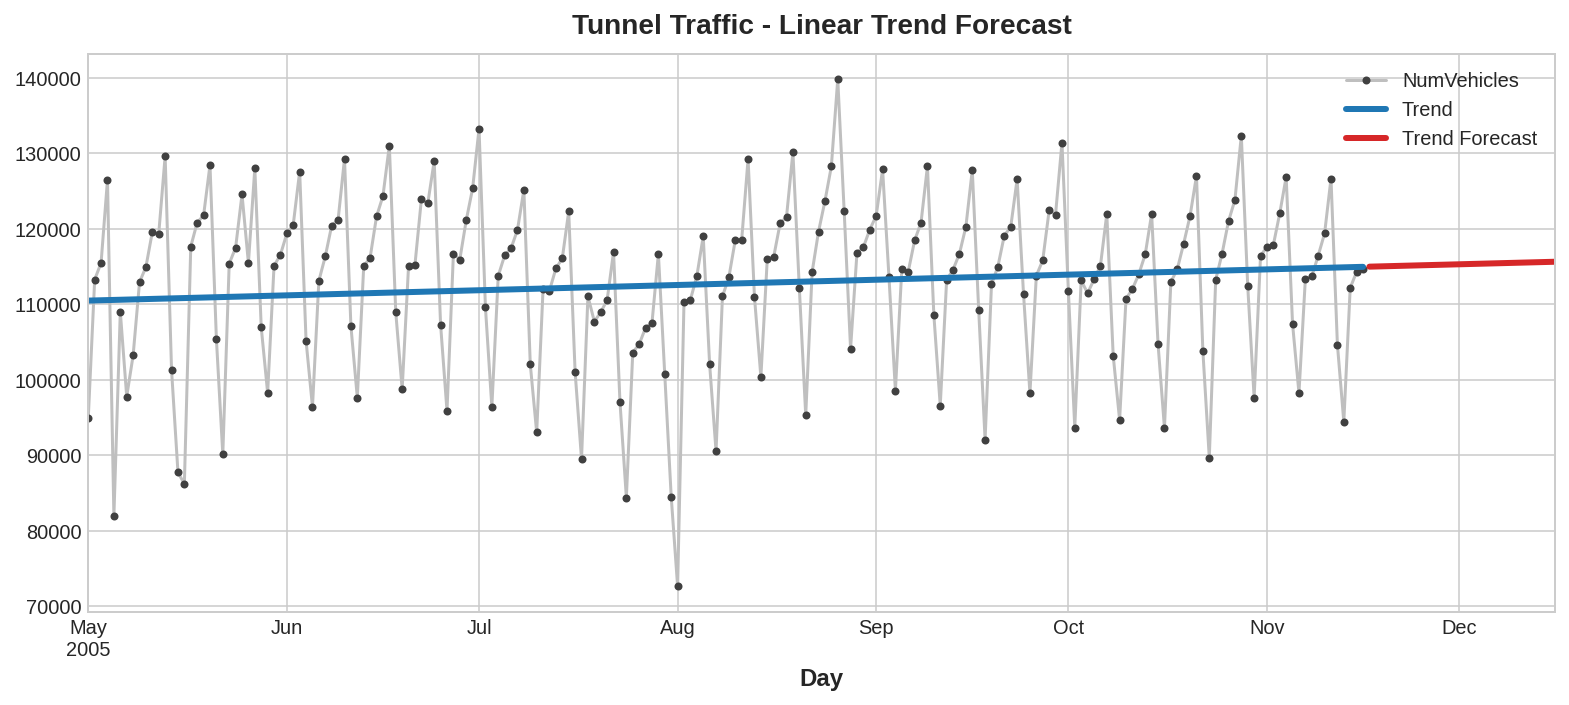

In [13]:
ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()